# Poisson regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
sns.set()  # Default seaborn theme, scaling & color palette

## Get the data

In [2]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


## Choose the features
Going to classify the number of fish (count)

In [3]:
f1 = fish_data['child']
f2 = fish_data['camper']
y1 = fish_data['count']

print(f1.shape, f2.shape, y1.shape)

(250,) (250,) (250,)


Text(0.5, 1.0, 'Note log scale')

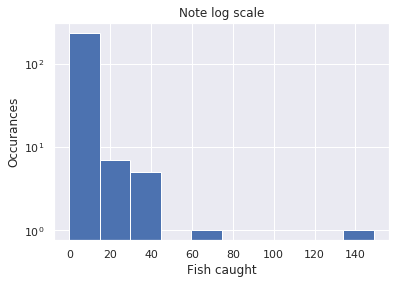

In [4]:
plt.hist(y1)
plt.ylabel('Occurances')
plt.xlabel('Fish caught')
plt.yscale('log')
plt.title('Note log scale')

## Build the model
* Using Poisson likelihood
* Book uses zero-inflated Poisson (ZIP) to take into account extra zeros - doesn't work well here.
* Use exponential inverse-link function to keep lambda values above zero

In [8]:
ZIP_reg = pm.Model()
with ZIP_reg:
    # psi = pm.Normal('psi', mu=0.5, sd=0.01)  # prior for choosing zero or poission dist
    alpha = pm.Normal('alpha', 0, 10)  # linear offset priors
    beta = pm.Normal('beta', 0, 10, shape=2)  # linear gradient priors
    
    lam = pm.math.exp(alpha + beta[0] * f1 + beta[1] * f2)  # exp inverse-link
    
    y = pm.Poisson('y', lam, observed=y1) # likelihood
    # y = pm.ZeroInflatedPoisson('y', lam, psi, observed=y1) # likelihood

In [9]:
with ZIP_reg:
    # start = pm.find_MAP()
    step = pm.Metropolis()  # doesn't work with nuts - count data?
    trace_ZIP_reg = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5524.60draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fc1d5d590>,
      dtype=object)

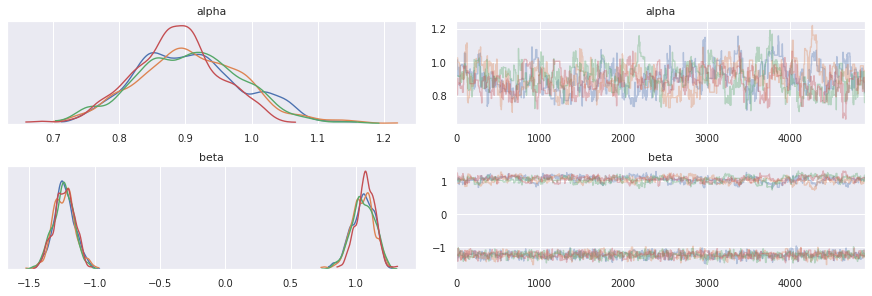

In [10]:
chain_ZIP_reg = trace_ZIP_reg[100:] 
pm.traceplot(chain_ZIP_reg)

## Look at the results
Plot sampled Poisson lambda parameter

In [11]:
children = [0, 1, 2, 3, 4] 
fish_count_pred_0 = [] 
fish_count_pred_1 = [] 
thin = 5  # Take every 5th sample
for n in children:
    without_camper = chain_ZIP_reg['alpha'][::thin] + chain_ZIP_reg['beta'][:,0][::thin] * n
    with_camper = without_camper + chain_ZIP_reg['beta'][:,1][::thin] 
    fish_count_pred_0.append(np.exp(without_camper)) 
    fish_count_pred_1.append(np.exp(with_camper))

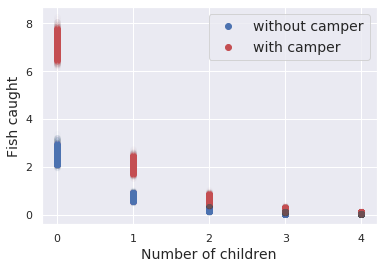

In [12]:
plt.plot(children, fish_count_pred_0, 'bo', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'ro', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children', fontsize=14)
plt.ylabel('Fish caught', fontsize=14)
plt.plot([], 'bo', label='without camper')
plt.plot([], 'ro', label='with camper')
plt.legend(fontsize=14)